In [1]:
import tika
from tika import parser
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
topics = 5

In [3]:
tika.initVM()
parsed = parser.from_file('article1.pdf')
metadados = parsed["metadata"]
texto = parsed["content"]

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [6]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [11]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
data = split_pdf(texto)
# print(data)

data = first_clear(data)
# print(data)

data = list(sent_to_words(data))

# Remove Stop Words
data_words_nostops = remove_stopwords(data)
bigram_mod, trigram_mod = bi_tri_gram(data_words_nostops)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

[['mapping'], [], ['bentham'], ['corpus'], ['concept', 'based'], ['navigation', 'hal'], ['id'], ['hal', 'submitted'], [], [], ['feb'], ['hal'], [], [], ['multi', 'disciplinary'], ['open'], ['access', 'archive'], [], [], ['deposit'], [], ['dissemination'], [], ['sci', 'entific'], ['research'], ['documents'], ['whether'], [], [], ['pub', 'lished'], [], [], [], ['documents'], ['may'], ['come'], ['teaching'], [], ['research'], ['institutions'], [], ['france'], ['abroad'], [], [], ['public'], [], ['private'], ['research'], ['centers', 'archive'], ['ouverte'], [], ['hal'], ['est', 'destinee'], ['au'], ['depot'], ['et'], [], ['la'], ['diffusion'], ['de'], ['documents', 'scientifiques'], ['de'], ['niveau'], ['recherche'], ['publies'], ['ou'], ['non', 'emanant'], ['des'], ['etablissements'], ['enseignement'], ['et'], ['de', 'recherche'], ['francais'], ['ou'], ['etrangers'], ['des'], ['laboratoires', 'publics'], ['ou'], ['prives', 'mapping'], [], ['bentham'], ['corpus'], ['concept', 'based', 'na

In [15]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]


In [16]:
# Human-readable
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                            update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [18]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"outlook" + 0.048*"term" + 0.042*"keyphrase" + 0.035*"evaluation" + '
  '0.029*"result" + 0.024*"lexical" + 0.023*"map" + 0.020*"word" + '
  '0.018*"access" + 0.018*"entity"'),
 (1,
  '0.055*"outlook" + 0.036*"work" + 0.033*"open" + 0.020*"task" + '
  '0.019*"interest" + 0.018*"text" + 0.015*"possible" + 0.009*"new" + '
  '0.009*"approach" + 0.009*"application"'),
 (2,
  '0.076*"bentham" + 0.043*"concept" + 0.040*"outlook" + 0.028*"mention" + '
  '0.024*"base" + 0.018*"semantic" + 0.015*"distributional" + '
  '0.012*"structure" + 0.012*"image" + 0.010*"tim"'),
 (3,
  '0.068*"corpus" + 0.055*"outlook" + 0.044*"network" + 0.040*"expert" + '
  '0.037*"journal" + 0.036*"page" + 0.025*"extraction" + 0.024*"user" + '
  '0.018*"use" + 0.017*"domain"'),
 (4,
  '0.076*"outlook" + 0.031*"digital" + 0.025*"datum" + 0.024*"humanity" + '
  '0.021*"issn" + 0.019*"interface" + 0.016*"node" + 0.014*"mining" + '
  '0.013*"improve" + 0.012*"manuscript"')]


In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.538173153407444

Coherence Score:  0.8273415828181128


In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.193482 -0.011208       1        1  24.624439
4     -0.040733  0.067633       2        1  23.364275
0     -0.058719  0.082491       3        1  18.456467
2     -0.068117 -0.146136       4        1  17.427422
1     -0.025914  0.007220       5        1  16.127396, topic_info=     Category        Freq           Term       Total  loglift  logprob
1     Default   86.000000        bentham   86.000000  30.0000  30.0000
2     Default  108.000000         corpus  108.000000  29.0000  29.0000
122   Default   70.000000        network   70.000000  28.0000  28.0000
773   Default   57.000000           term   57.000000  27.0000  27.0000
95    Default   64.000000         expert   64.000000  26.0000  26.0000
...       ...         ...            ...         ...      ...      ...
1394   Topic5    8.738817            url   52.026062   0.0407  -4.7796
1412   Topic5    7.667866  international   44.048832   0.0764  -4.9103
1437   Topic5    6.513677     conference   38.580116   0.0458  -5.0734
1424   Topic5    5.268593     linguistic   31.103319   0.0491  -5.2856
1436   Topic5    5.216756     proceeding   30.084045   0.0725  -5.2955

[218 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
12        3  0.983045         access
469       1  0.800880          allow
170       5  0.889443           also
349       4  0.945653       analysis
550       3  0.838596       annotate
...     ...       ...            ...
763       2  0.884756  visualization
675       4  0.847626            way
640       3  0.967659           word
180       5  0.986131           work
241       3  0.951702          would

[223 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 3, 2])

In [21]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)

In [27]:
pprint(ldamallet.show_topics())
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  '0.101*"bentham" + 0.036*"keyphrase" + 0.029*"manuscript" + '
  '0.027*"information" + 0.025*"transcribe" + 0.023*"work" + 0.017*"give" + '
  '0.014*"scholar" + 0.012*"relate" + 0.011*"large"'),
 (1,
  '0.119*"corpus" + 0.036*"term" + 0.034*"tool" + 0.030*"search" + '
  '0.027*"extraction" + 0.019*"domain" + 0.015*"follow" + 0.014*"year" + '
  '0.014*"context" + 0.013*"date"'),
 (2,
  '0.050*"concept" + 0.046*"journal" + 0.041*"mention" + 0.031*"datum" + '
  '0.027*"mining" + 0.026*"user" + 0.023*"base" + 0.022*"interest" + '
  '0.020*"find" + 0.019*"interface"'),
 (3,
  '0.084*"network" + 0.042*"map" + 0.034*"document" + 0.033*"text" + '
  '0.029*"create" + 0.023*"project" + 0.023*"dbpedia" + 0.023*"issn" + '
  '0.021*"humanity" + 0.017*"list"'),
 (4,
  '0.050*"node" + 0.044*"term" + 0.043*"expert" + 0.034*"digital" + '
  '0.032*"access" + 0.030*"page" + 0.028*"link" + 0.026*"open" + 0.022*"base" '
  '+ 0.019*"work"')]

Coherence Score:  0.8321814643919236


In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


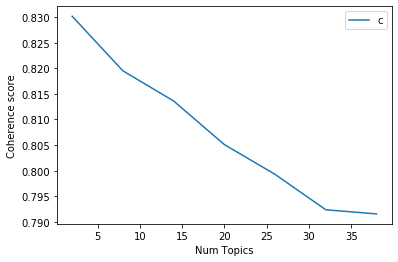

In [29]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()